## Importations

In [1]:
# Run Keras on CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152

In [2]:
# Importations
import sys
sys.path.append(os.path.join('utils'))

from configtf2 import *
import CPutils_tf2
import feature_extraction_tf2

In [3]:
# GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# Custom metrics

In [4]:
# Backend importation
import tensorflow.keras.backend as K

# Custom metrics
def specificity(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# One class accuracy
INTERESTING_CLASS_ID = 1  # Choose the class of interest
def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

# Loss function 
def specificity_loss_wrapper():
    """A wrapper to create and return a function which computes the specificity loss, as (1 - specificity)

    """
    # Define the function for your loss
    def specificity_loss(y_true, y_pred):
        return 1.0 - specificity(y_true, y_pred)

    return specificity_loss    # we return this function object

# Data (Gray)

In [5]:
# GLobal directories
BASE_PATH = os.path.join('..', 'data')

In [17]:
# Load original dataset, smote augmented, and independent testing set
Data, labels = cload(os.path.join(BASE_PATH, 'OR_data.lzma'), compression='lzma')
Xtrain, ytrain, Xval, yval = cload(os.path.join(BASE_PATH, 'train_val_expanded.lzma'), compression='lzma')
Xtest, ytest = cload(os.path.join())

<Figure size 432x288 with 0 Axes>

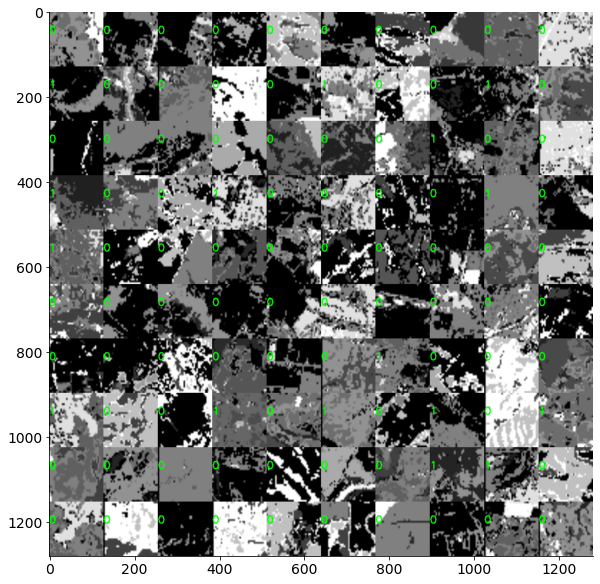

In [7]:
# Sample (quick look 100 images from dataset)
CPutils_tf2.plt_style(figsize=(10,10))
_ = CPutils_tf2.collage(images=Data * 255., 
                        seed=123,
                        imagesize=(128,128),
                        collagesize=(10,10),
                        sampleSize=100,
                        readImage=False,
                        show=False,
                        labels=labels.astype('str'))
plt.imshow(np.array(_)[0,:,:,:], cmap='gray')

# CNNet

In [8]:
# Import model and initialize a testing model
from nets_tf2.firenet import FireNet
dims = (Xtrain.shape[2], Xtrain.shape[1], 1)
model = FireNet.build_model(width=dims[0], height=dims[1], depth=dims[2], classes=2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 31, 38, 32)        73        
_________________________________________________________________
activation (Activation)      (None, 31, 38, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 38, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 19, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 15, 19, 64)        2400      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 19, 64)        0

## Class weights

In [9]:
from sklearn.utils import class_weight
classWeight = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(ytrain),
                                                y=ytrain)
classWeight = {idx:i for idx,i in enumerate(classWeight)}
classWeight

{0: 1.002186103982511, 1: 0.9978234125106463}

## Model Training

In [10]:
# Callbacks
plot_losses = CPutils_tf2.TrainingPlot(5)
checkpoint = ModelCheckpoint(filepath=os.path.join('MAcc.h5'), 
                             save_best_only=True,
                             monitor='val_accuracy')
checkpoint2 = ModelCheckpoint(filepath=os.path.join('MAcc1.h5'), 
                             save_best_only=True,
                             monitor='val_single_class_accuracy')
callback_list = [plot_losses, checkpoint, checkpoint2]

In [11]:
# Optimizer
from tensorflow.keras.optimizers import Adagrad

# Compile our model (this needs to be done after our setting our layers to being non-trainable)
print("[INFO] compiling model...")

# Global parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

# Optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Compilation
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[specificity, sensitivity, single_class_accuracy, 'accuracy'])

[INFO] compiling model...


In [12]:
# Global parameters
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

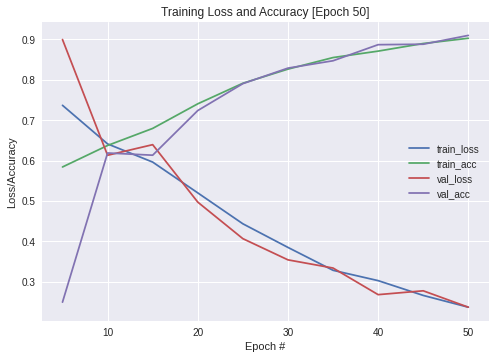

Epoch 47/50
659/659 [==============================] - 7s 11ms/step - loss: 0.2244 - specificity: 0.8949 - sensitivity: 0.9085 - single_class_accuracy: 0.9052 - accuracy: 0.9085 - val_loss: 0.2283 - val_specificity: 0.9005 - val_sensitivity: 0.9072 - val_single_class_accuracy: 0.6893 - val_accuracy: 0.9067
Epoch 48/50
659/659 [==============================] - 7s 11ms/step - loss: 0.2330 - specificity: 0.8905 - sensitivity: 0.9058 - single_class_accuracy: 0.8983 - accuracy: 0.9058 - val_loss: 0.2323 - val_specificity: 0.8983 - val_sensitivity: 0.9087 - val_single_class_accuracy: 0.6917 - val_accuracy: 0.9083
Epoch 49/50
659/659 [==============================] - 7s 11ms/step - loss: 0.2139 - specificity: 0.8979 - sensitivity: 0.9106 - single_class_accuracy: 0.9021 - accuracy: 0.9106 - val_loss: 0.2535 - val_specificity: 0.8917 - val_sensitivity: 0.8997 - val_single_class_accuracy: 0.6729 - val_accuracy: 0.8992
Epoch 50/50
659/659 [==============================] - 7s 11ms/step - loss: 

In [13]:
# Train (explicit validation and train sets)
from tensorflow.keras.utils import to_categorical
weightsTrain = False
print("Training the model...")
H = model.fit(Xtrain, 
              to_categorical(ytrain).astype(int),
              validation_data=(Xval, to_categorical(yval).astype(int)),
              batch_size=BS, 
              epochs=EPOCHS,
              verbose=1,
              callbacks=callback_list,
              class_weight=classWeight if weightsTrain else None,)

## Evaluation

In [14]:
# Importations for evaluation
from sklearn.metrics import (mean_squared_error, roc_auc_score, auc, 
                             confusion_matrix, accuracy_score, classification_report,
                             precision_score, recall_score, f1_score, cohen_kappa_score)

### Validation set

In [15]:
# Predict over the original images
# Get Test truth and hat
y_hat = model.predict(Xval)
ytest = yval

# Evaluation
print("Test accuracy [%]:", np.round(accuracy_score(y_true=ytest, y_pred=y_hat.argmax(1)) * 100, 2))
print("Precision Score:", np.round(precision_score(y_true=ytest, y_pred=y_hat.argmax(1)),3))
print("Recall score:", np.round(recall_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("F1 score:", np.round(f1_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("Cohen Kappa score:", np.round(cohen_kappa_score(ytest, y_hat.argmax(1)),3))
print("ROC AUC score:", np.round(roc_auc_score(y_true=ytest, y_score=y_hat[:,1]), 3))
tn, fp, fn, tp = confusion_matrix(ytest, y_hat.argmax(1)).ravel()
print("Specificity:", tn / (tn+fp))
print("Sensitivity:", tp / (tp+fn))
print(confusion_matrix(ytest, y_hat.argmax(1)))

Test accuracy [%]: 92.01
Precision Score: 0.719
Recall score: 0.983
F1 score: 0.83
Cohen Kappa score: 0.78
ROC AUC score: 0.987
Specificity: 0.9045996592844975
Sensitivity: 0.9828178694158075
[[3186  336]
 [  15  858]]


<Figure size 576x396 with 0 Axes>

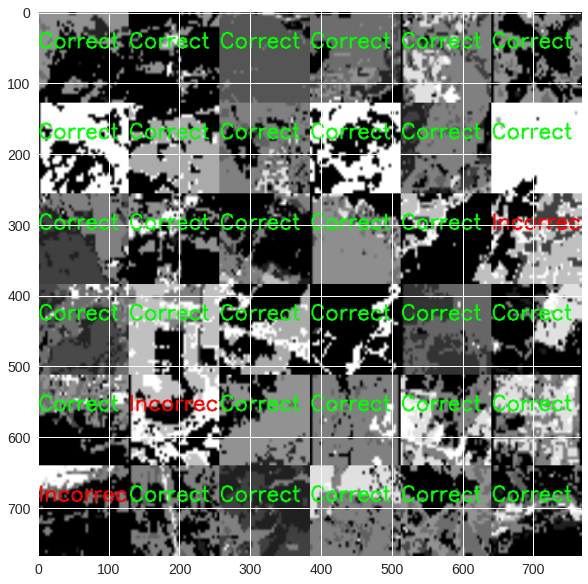

In [16]:
# Collage
CPutils_tf2.plt_style(figsize=(10,10))
_ = CPutils_tf2.predicted_collage(images=Xval, 
                                  rescale=255.,
                                  model=model,
                                  sampleSize=-1,
                                  collagesize=(6,6),
                                  labels=to_categorical(yval),
                                  imagesize=(128,128), 
                                  show=False)
# plt.imsave(os.path.join(VAL_PATH, 'preduiction_outputs.png'), cv2.cvtColor(_[0], cv2.COLOR_BGR2RGB))

### Whole dataset

In [17]:
# Predict over the original images
# Get Test truth and hat
y_hat = model.predict(np.expand_dims(Data, -1))
ytest = labels

# Evaluation
print("Test accuracy [%]:", np.round(accuracy_score(y_true=ytest, y_pred=y_hat.argmax(1)) * 100, 2))
print("Precision Score:", np.round(precision_score(y_true=ytest, y_pred=y_hat.argmax(1)),3))
print("Recall score:", np.round(recall_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("F1 score:", np.round(f1_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("Cohen Kappa score:", np.round(cohen_kappa_score(ytest, y_hat.argmax(1)),3))
print("ROC AUC score:", np.round(roc_auc_score(y_true=ytest, y_score=y_hat[:,1]), 3))
tn, fp, fn, tp = confusion_matrix(ytest, y_hat.argmax(1)).ravel()
print("Specificity:", tn / (tn+fp))
print("Sensitivity:", tp / (tp+fn))
print(confusion_matrix(ytest, y_hat.argmax(1)))

Test accuracy [%]: 94.11
Precision Score: 0.783
Recall score: 0.976
F1 score: 0.869
Cohen Kappa score: 0.831
ROC AUC score: 0.988
Specificity: 0.9324276264314674
Sensitivity: 0.9755681818181818
[[13109   950]
 [   86  3434]]
